# High Voltage Battery Cell Testing with 10A Current Using a First Order Thevenin Battery Model

## Perform Calculations to Find the Resistance and Capacitance of the High Voltage Battery Cell

In [2]:
import sys
!{sys.executable} -m pip install n

  Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib ipympl
# read data from the csv file for 1A constant cell run
ocv_data = pd.read_csv("1A Constant Cell 1 Run 1.csv")
ocv_soc = ocv_data["LOAD_CAPACITY"].to_list()
ocv_voltage =  ocv_data["DMM_VOLTAGE"].to_list()

# find a polynomial fit of the voltage vs. soc graph
ocv_fit = np.polynomial.polynomial.Polynomial.fit(ocv_data["LOAD_CAPACITY"], ocv_data["DMM_VOLTAGE"], 10)

# plotting the graphs for open circuit voltage (ocv)
plt.figure()
# plot the original ocv graph
plt.plot(ocv_soc, ocv_voltage, label="Original graph")
# plot the fitted ocv graph
plt.plot(ocv_soc, ocv_fit(ocv_data["LOAD_CAPACITY"]), label="Fitted graph")
plt.legend(loc="upper right")
plt.title("Voltage vs. State of Charge fitted graph")
plt.xlabel("State of Charge (mAh)")
plt.ylabel("Voltage (V)")
plt.show()

ModuleNotFoundError: No module named 'pandas'

### Read Data

In [17]:
# read data from the csv file for the 10A cell run
transient_data = pd.read_csv("0A90S-10A90S Cell 2 Run 1.csv")
# subtract the values of the 1A constant cell run (open circuit voltage) from the 10A cell run to get the corrected voltage values 
transient_data['SOC_CORRECTED_DMM_VOLTAGE'] = transient_data['DMM_VOLTAGE'] - ocv_fit(transient_data['LOAD_CAPACITY'])

# convert data columns in the csv file into lists to make the analysis process easier
corrected_voltage = transient_data['SOC_CORRECTED_DMM_VOLTAGE'].to_list()
time_stamps = transient_data['TIME_STAMP'].to_list()
soc = transient_data['LOAD_CAPACITY'].to_list()

### Find Voltage Drop Points

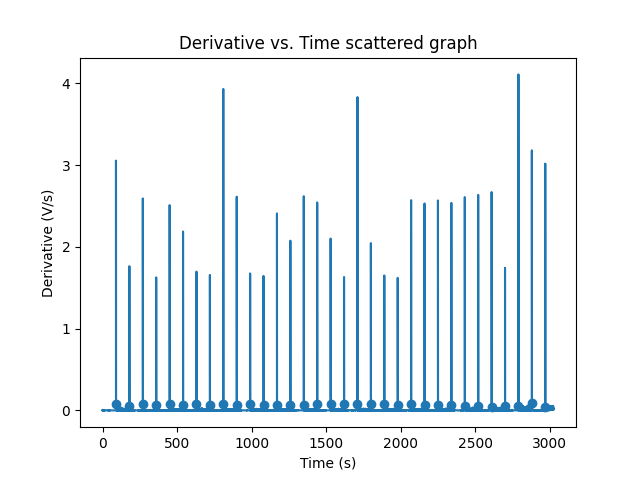

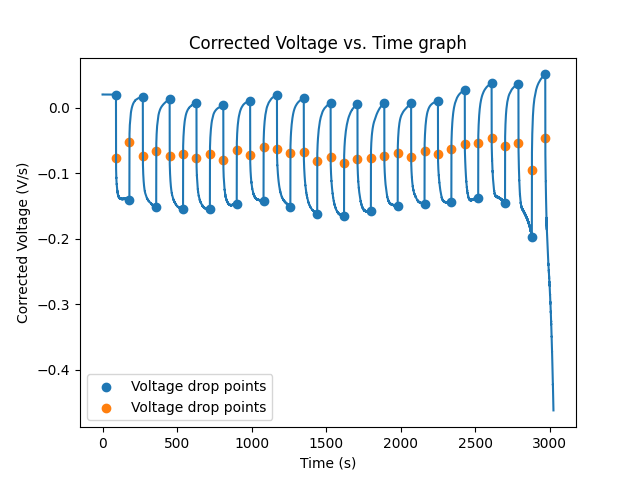

In [18]:
import scipy

# find voltage drop points by finding the derivatives at every point of the 10A cell run graph. A voltage drop will have a sharp drop/rise in the graph, indicating a relatively high derivative 
derivatives = [0]

for i in range(len(transient_data) - 1):
    derivatives.append((corrected_voltage[i + 1] - corrected_voltage[i]) / (time_stamps[i + 1] - time_stamps[i]))

transient_data['SOC_CORRECTED_DMM_VOLTAGE_DER'] = derivatives

# find voltage drop points using the scipy library 
(peaks, properties) = scipy.signal.find_peaks(np.abs(transient_data['SOC_CORRECTED_DMM_VOLTAGE_DER']), height=0.5, threshold=0.5, distance=100, width=1, rel_height=0.7)
volt_list_one = list(transient_data['SOC_CORRECTED_DMM_VOLTAGE'][np.round(properties['left_ips'])])
volt_list_two = list(transient_data['SOC_CORRECTED_DMM_VOLTAGE'][np.round(properties['right_ips'])])

# plot the derivatives, then scatter plot the voltage drop points found using scipy to verify whether the voltage drop points found from taking the derivatives is accurate
plt.figure()
plt.plot(transient_data['TIME_STAMP'], np.abs(transient_data['SOC_CORRECTED_DMM_VOLTAGE_DER']))
plt.scatter(transient_data['TIME_STAMP'][np.round(properties['left_ips'])], np.abs(volt_list_two))
plt.title("Derivative vs. Time scattered graph")
plt.xlabel("Time (s)")
plt.ylabel("Derivative (V/s)")
plt.show()

# double verify the voltage drop points by scatter plot the voltage drop points, but this time on the corrected voltage vs. time graph
plt.figure()
plt.plot(transient_data['TIME_STAMP'], transient_data['SOC_CORRECTED_DMM_VOLTAGE'])
plt.scatter(transient_data['TIME_STAMP'][np.round(properties['left_ips'])], volt_list_one, label="Voltage drop points")
plt.scatter(transient_data['TIME_STAMP'][np.round(properties['right_ips'])], volt_list_two, label="Voltage drop points")
plt.legend(loc="lower left")
plt.title("Corrected Voltage vs. Time graph")
plt.xlabel("Time (s)")
plt.ylabel("Corrected Voltage (V/s)")
plt.show()

### Find the Internal Resistance (Resistance 0 in the Thevenin Model) of the Cell

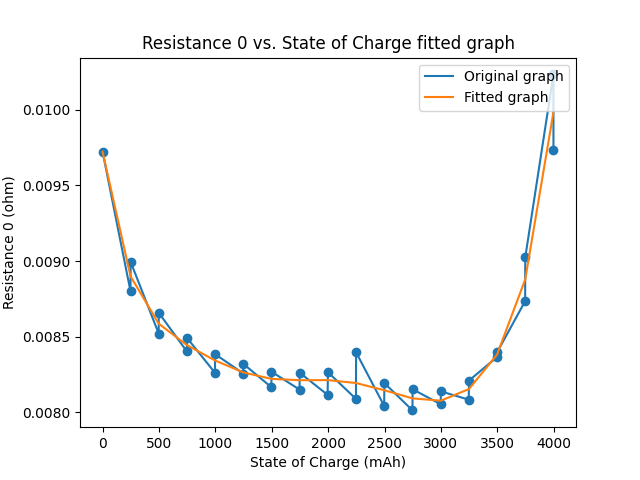

In [19]:
# corr_volt_to_index declares a dictionary of voltage corresponding to 
corr_volt_to_index = {v: index for index, v in enumerate(corrected_voltage)}
resistance_zero = [abs(v - volt_list_one[i]) / 10 for i, v in enumerate(volt_list_two)]
v_zero_drop_soc = [soc[corr_volt_to_index[x]] for i, x in enumerate(volt_list_two)]

# plot the original and fitted graph of resistor 0 with respect to soc, along with calculated data points scattered
r_zero_fit = np.polynomial.polynomial.Polynomial.fit(v_zero_drop_soc, resistance_zero, 10)
plt.figure()
plt.plot(v_zero_drop_soc, resistance_zero, label="Original graph")
plt.plot(v_zero_drop_soc, r_zero_fit(np.array(v_zero_drop_soc)), label="Fitted graph")
plt.scatter(v_zero_drop_soc, resistance_zero)
plt.legend(loc="upper right")
plt.title("Resistance 0 vs. State of Charge fitted graph")
plt.xlabel("State of Charge (mAh)")
plt.ylabel("Resistance 0 (ohm)")
plt.show()

### Find Resistance 1 of the Cell

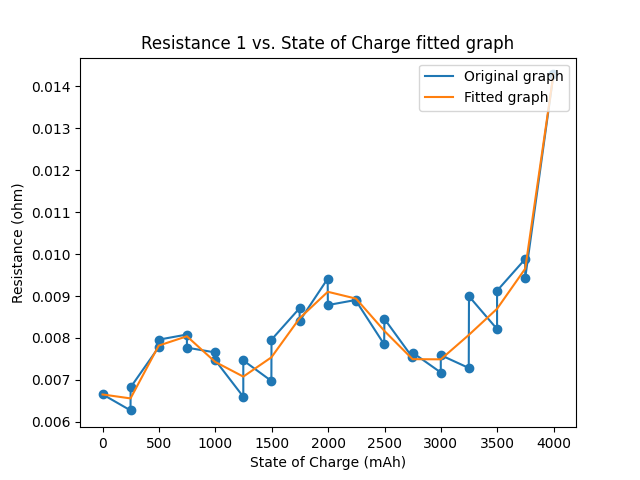

In [20]:
# calculate resistance 1 using ohm's law 
resistance_one = [abs(v - volt_list_two[i - 1]) / 10 for i, v in enumerate(volt_list_one) if i != len(volt_list_two) - 1]
r_one_soc = v_zero_drop_soc[:-1]

# plot the original and fitted graph of resistor 1 with respect to soc, along with calculated data points scattered
r_one_fit = np.polynomial.polynomial.Polynomial.fit(r_one_soc, resistance_one, 10)
plt.figure()
plt.plot(r_one_soc, resistance_one, label="Original graph")
plt.plot(r_one_soc, r_one_fit(np.array(r_one_soc)), label="Fitted graph")
plt.scatter(r_one_soc, resistance_one)
plt.legend(loc="upper right")
plt.title("Resistance 1 vs. State of Charge fitted graph")
plt.xlabel("State of Charge (mAh)")
plt.ylabel("Resistance (ohm)")
plt.show()

### Calculate Capacitance of the Cell

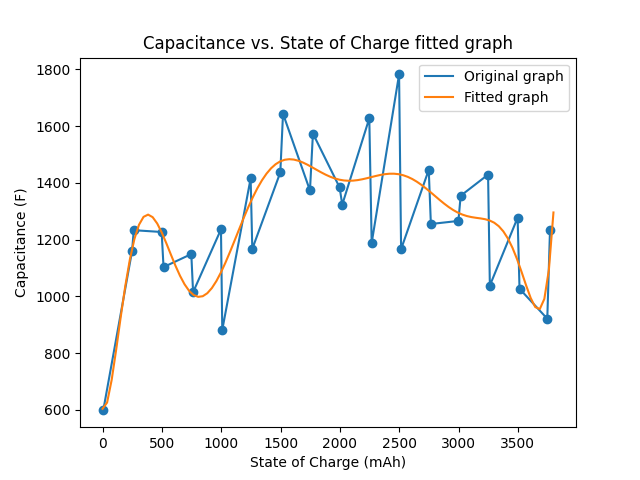

In [27]:
import math

# find the voltages at the half lives
half_life_v = [(volt + volt_list_one[n + 1]) / 2 for n, volt in enumerate(volt_list_two) if n != len(volt_list_two) - 1]

# declare new lists and variables for the purpose of finding the capacitance at each half life
half_life_soc = []
half_lives = []
half_life_voltage = []
capacitance_list = []
new_r_one = []
ln_two = math.log(2)

# the formula for calculating capacitance at half life is C = t/(R*ln(2)).

# find the time at each half life
for x in range(0, len(half_life_v) - 1):
    if x < len(volt_list_two) - 1:
        # find the index of the voltage before and after it rises/drops
        v_initial_index = corr_volt_to_index[volt_list_two[x]]
        v_final_index = corr_volt_to_index[volt_list_one[x + 1]]
        # compile a new voltage list that goes from the initial to final voltage to reduce the search scope
        new_v_list = corrected_voltage[v_initial_index:v_final_index]
        # find the closest value in the new voltage list that corresponds to the half life voltage and add it to an updated list of half life voltages
        new_half_life_v = min(new_v_list, key=lambda v:abs(v - half_life_v[x]))
        # store each half life voltage to new_half_life_v
        half_life_voltage.append(new_half_life_v)
        # find time and append it to the list half_life
        half_life_index = corr_volt_to_index[new_half_life_v]
        half_life = time_stamps[half_life_index] - time_stamps[v_initial_index]
        half_lives.append(half_life)

# find soc corresponding to the half lives
for v in half_life_voltage: 
    h_life_soc = soc[corr_volt_to_index[v]]
    half_life_soc.append(h_life_soc)

# calculate the capacitance at each half life
for i, x in enumerate(half_life_soc):
    capacitance = half_lives[i] / (r_one_fit(x) * ln_two)
    new_r_one.append(r_one_fit(x))
    capacitance_list.append(capacitance)

# plot original and fitted graph of capacitance with respect to soc
capacitance_fit = np.polynomial.polynomial.Polynomial.fit(half_life_soc, capacitance_list, 10)
plt.figure()
plt.plot(half_life_soc, capacitance_list, label="Original graph")
plt.plot(np.linspace(0, 3800, num=100), capacitance_fit(np.linspace(0, 3800, num=100)), label="Fitted graph")
plt.scatter(half_life_soc, capacitance_list)
plt.legend(loc="upper right")
plt.title("Capacitance vs. State of Charge fitted graph")
plt.xlabel("State of Charge (mAh)")
plt.ylabel("Capacitance (F)")
plt.show()


### Calculate Total Resistance of the Cell

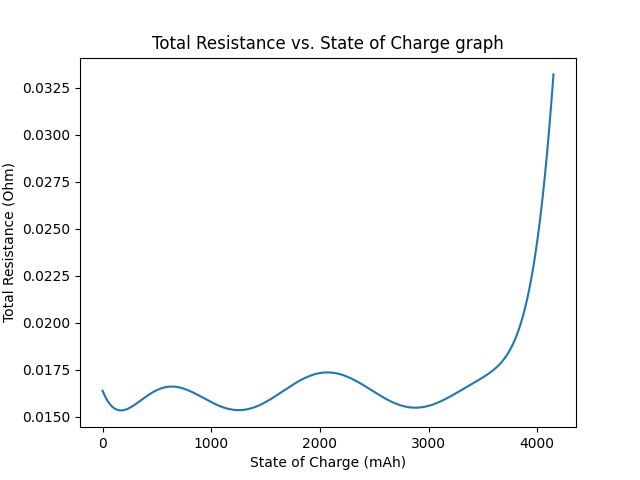

In [28]:
# plot the graph of total resistance vs. soc by adding the fitted graphs of resistance one and two
total_resistance = [r_zero_fit(i) + r_one_fit(i) for i in soc]
plt.figure()
plt.plot(soc, total_resistance)
plt.title("Total Resistance vs. State of Charge graph")
plt.xlabel("State of Charge (mAh)")
plt.ylabel("Total Resistance (Ohm)")
plt.show()

## Perform Simulations Using Values Obtained from Calculations

### Find a simulated list for state of charge by taking the integral of current with respect to time 

In [29]:
# convert current from the csv file into a list
current = transient_data["LOAD_CURRENT"].to_list()
# convert the unit of current from A to mA and the unit of time from seconds to hours, since the unit for state of charge is mAh
mili_amp = [i * 1000 for i in current]
time_sec = [t / 3600 for t in time_stamps]

# declare variables for the purpose of calculating the integral and storing the state of charge calculated from taking the integral
simulated_soc = []
integral = 0

# dictionary that corresponds state of charge to index in order to speed up the calculation
soc_to_index = {s: i for i, s in enumerate(soc)}

# calculate the integral using the rectangular method, since the current vs. time graph is always either at constant 0A or 10A
for index, m_amp in enumerate(mili_amp): 
    if index != 0:
        delta_x = time_sec[index] - time_sec[index - 1]
        integral += delta_x * m_amp 
        simulated_soc.append(integral)

### Find simulated voltage values at each simulated soc value using Ohm's law

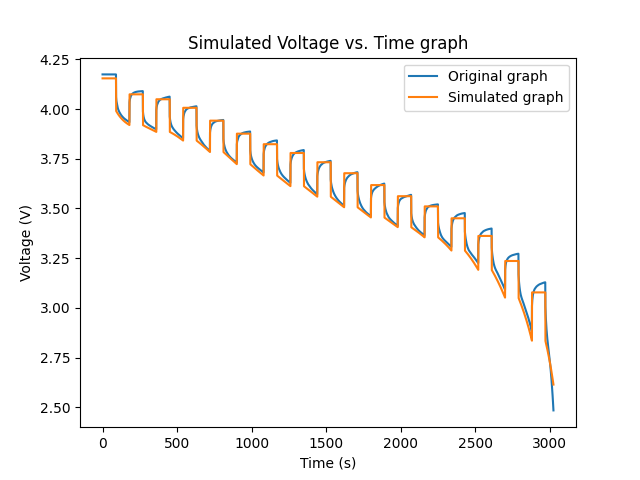

In [32]:
# use the simulated list of state of charge to find the corresponding open circuit voltages based on the csv file for "constant 1A cell run"
simulated_voltage_drop = []
sim_original_voltage = []

# find simulated voltage values at each soc using Ohm's law
for i, x in enumerate(simulated_soc): 
    if i != 0:
        simulated_resistance = r_zero_fit(x) + r_one_fit(x)
        simulated_voltage_drop = current[i] * simulated_resistance
        simulated_original_voltage = ocv_fit(x) - simulated_voltage_drop
        sim_original_voltage.append(simulated_original_voltage)

# plot graph
plt.figure()
plt.title("Simulated Voltage vs. Time graph")
plt.plot(time_stamps, transient_data['DMM_VOLTAGE'], label="Original graph")
plt.plot(time_stamps[2:], sim_original_voltage, label="Simulated graph")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend(loc="upper right")
plt.show()

### Find simulated voltage values by simulating the charging and discharging action of the capacitor

C:\Users\Enoch\AppData\Local\Temp\ipykernel_2984\117190244.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


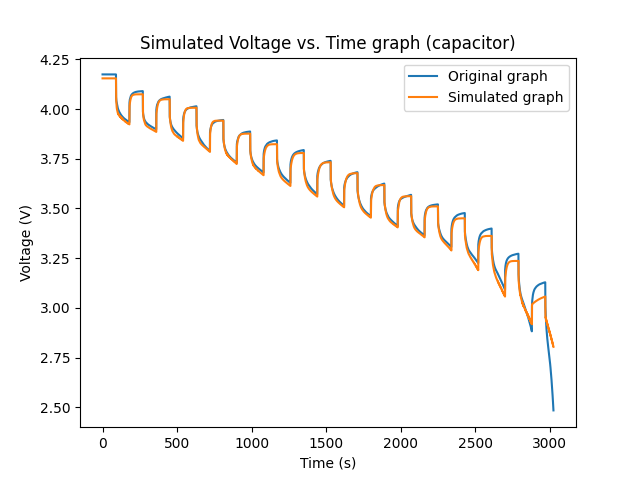

In [33]:
sim_voltage = []
charge = 0
# simulate the change in voltage of the battery cell using the change in charge of the capacitor. The formula is C = Q / V
for i, t in enumerate(time_stamps): 
    if i != len(time_stamps) - 1:
        # find all values at the current time stamp
        e_current = current[i]
        e_soc = soc[i]
        capacitance = capacitance_fit(e_soc)
        r0 = r_zero_fit(e_soc)
        r1 = r_one_fit(e_soc)
        # calculate total voltage across resistor 1 and capacitor using C = Q / V
        voltage_rc = charge / capacitance
        # calculate voltage across resistor 0 and 1 using Ohm's law
        voltage_r0 = e_current * r0
        voltage_ocv = ocv_fit(e_soc)
        current_r1 = voltage_rc / r1
        current_c = e_current - current_r1
        # calculate the change in charge and update the charge value
        delta_charge = current_c * (time_stamps[i + 1] - time_stamps[i])
        charge += delta_charge
        # based on the updated charge value, update the total voltage across resistor 1 and capacitor using C = Q / V
        updated_rc_voltage = charge / capacitance_fit(soc[i + 1])
        sim_voltage.append(voltage_ocv - updated_rc_voltage - voltage_r0)

# plot graph
plt.figure()
plt.title("Simulated Voltage vs. Time graph (capacitor)")
plt.plot(time_stamps, transient_data['DMM_VOLTAGE'], label="Original graph")
plt.plot(time_stamps[:-1], sim_voltage, label="Simulated graph")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend(loc="upper right")
plt.show()

In [1]:
new_v = min(corrected_voltage, key=lambda x:abs(x - 341))
print(new_v)

NameError: name 'corrected_voltage' is not defined